# **Exploring Machine Learning Models to Differentiate Poisonous Mushrooms**

## Introduction and Context
The aim of this project is to demonstrate the utility of Machine Learning (ML) in real world application, while verifying the results of a published journal. Specifically, the focus of this project will be to classify mushroom as either edible or poisonous, with respect to various attributes (such as colour, measurements or season). We will reproduce the findings of this article: [Mushroom data creation, curation, and simulation to support classification tasks](https://www.nature.com/articles/s41598-021-87602-3#Fig4) by Wagner et al. We will also discuss or experiment with alternative methods or models, depending on the project's outcome. 

In short, Wagner et al. used two datasets: 'primary' and 'secondary' for their mushroom classfication study. 
* The primary data was based on a text book that regarded mushroom identification with respect to taxonomy.
* The secondary data comprised simulated mushroom entries based on a 1987 dataset. 

Using the two datsets, they experimented with four models: **naive Bayes**, **logistic regression**, and **linear discriminant analysis** (LDA), and **random forests** (RF) to predict whether mushrooms were 'edible' (e) or 'poisonous' (p). The findings evidenced RF to be the best model with its perfect accuracy score of 1.0.  

Our approach will be similar or identical to that of Wagner et al.'s. In summary, we will be using the:
* same set of features and pre-processing — see Wagner et al.'s 'binary classification' section in 'methods' for details
* same classifiers — Note that Wagner et al. did not provide the model parameters that they used. 
    * Therefore, we will be using GridSearch to find best combination of parameters.
* same training/test splitting (80-20%) — Wagner et al. did not provide the splitting seed they used. 
    * Therefore, it will be left random (default).
* same evaluation metrics. ie. f2-score, accuracy, boxplots and AUC curves 

If the perfect model (random forest) is not replicable, we will try to find the best alternative model for the dataset.

### Importing modules and datasets

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings; warnings.filterwarnings("ignore") # cleaner display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, make_scorer, accuracy_score, fbeta_score

## Pre-processing Replication

In [2]:
df1 = pd.read_csv('primary_data.csv', sep=';') # primary
df2 = pd.read_csv('secondary_data.csv', sep=';') # secondary

### Missing Values Replication
* Variables with more then 50% missing values are removed.
* Then, the most frequent single imputation replaces the missing data.

In [3]:
for df in [df1,df2]:
    df = df.loc[:,(df.isna().sum() <= df.shape[0]/2)]

    for column in df.columns:
        mode_value = df[column].value_counts().index[0]
        df[column] = df[column].fillna(mode_value)    

### Data Transformation
* The data are split into training and testing sets (80-20).
* The binary target is LabelEncoded
* Nominal variables are OneHotEncoded

* Below we will also clean some numerical values. Note that we are assuming the average when a measurement range is given for the following three features in the primary dataset

In [4]:
for col in ['cap-diameter','stem-height', 'stem-width']:
    df1[col] = df1[col].str[ 
        1:-1                                            # Leave out the square brackets (dtype is str)  
    ].apply(
        lambda x: x.split(',')                          # Turn elements between square brackets into a list, each element is still str
    ).apply(
        lambda x: ((float(x[0]))+(float(x[-1])))/2      # When both elements are float, return their average
    ) 

### Seperating the Nominal and Numerical Variables

In [5]:
df12_numerics = ['cap-diameter','stem-height', 'stem-width'] # shared by both datasets
df1_nominals = []
df2_nominals = []
for column_name in df1.columns:
    if column_name not in df12_numerics:
        df1_nominals.append(column_name)
for column_name in df2.columns:
    if column_name not in df12_numerics:
        df2_nominals.append(column_name)
        
# y-variable removed to avoid mixing with other nominal variables
df1_nominals.remove('class') 
df2_nominals.remove('class')

In [6]:
X1 = df1.copy()
y1 = X1.pop('class')
    
label_encoder1 = LabelEncoder().fit(y1) 
y1 = label_encoder1.transform(y1) 
        
encoded_noms1 = OneHotEncoder(sparse_output=False).fit_transform(X1[df1_nominals])
X1 = np.concatenate((X1[df12_numerics], encoded_noms1), axis=1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

In [7]:
X2 = df2.copy()
y2 = X2.pop('class')
    
label_encoder2 = LabelEncoder().fit(y2) 
y2 = label_encoder2.transform(y2) 
        
encoded_noms2 = OneHotEncoder(sparse_output=False).fit_transform(X2[df2_nominals])
X2 = np.concatenate((X2[df12_numerics], encoded_noms2), axis=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

Numerical variables are unchanged — no scaling.

## Modelling (replication of Wagner et al.'s):

An 'itertools.product for loop' is the pipeline for collecting every combination of "*group*", "*model*" and "*scoring system*". The cross-validation is five-fold.

#### Preparing primary and secondary *groups* as dictionaries for the pipeline
Both training and testing sets are stored for primary and secondary *groups* using dictionaries. The dictionaries will also be responsible for capturing their respective parameters found during cross-validation.

In [8]:
primary =  {
    'X_train': X1_train,
    'X_test': X1_test,
    'y_train': y1_train,
    'y_test' : y1_test
}
secondary = {
    'X_train': X2_train,
    'X_test': X2_test,
    'y_train': y2_train,
    'y_test' : y2_test
}

#### Preparing *models* for the pipeline
* Four models need to be made:
    * naive Bayes
    * logistic regression
    * linear discriminant analysis (LDA)
    * random forests (RF) 
* We cannot replicate parameters because none were provided in the original article. 
    * Therefore, GridSearch will be used to find the possible parameter optimisation.
    * Below, each model's respective param_grids are initialised:

In [9]:
rf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],     
}

lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
} 

lda_param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto']
}

nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# all parameters are arbitrarily chosen

#### Preparing *Scoring systems* for the pipeline
Both 'accuracy' and 'f2-score' are to be collected for ROC curves.

In [10]:
f2_scorer = make_scorer(fbeta_score, beta=2)
# fbeta_score is f2-score 
# twice as much importance is assigned to recall than to precision, this means the beta parameter equals 2

scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f2_score': make_scorer(fbeta_score, beta=2)
}

In [11]:
for dict_set, scoring_system, model in itertools.product( 
    # itertools will get every combination
    (
        primary, 
        secondary
    ),
    (
        'accuracy',
        f2_scorer
    ),
    (
    GaussianNB(),
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    RandomForestClassifier(bootstrap=True, oob_score=True)
    )
):
    if isinstance(model, RandomForestClassifier):
        param_grid = rf_param_grid
        prefix = 'rf'
    
    elif isinstance(model, LinearDiscriminantAnalysis):
        param_grid = lda_param_grid
        prefix = 'lda'
        
    elif isinstance(model, LogisticRegression):
        param_grid = lr_param_grid
        prefix = 'lr'
        
    elif isinstance(model, GaussianNB):
        param_grid = nb_param_grid
        prefix = 'nb'
    
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5,  
        scoring=scoring_system,
        n_jobs=-1
    ).fit(
        dict_set['X_train'], # X_train
        dict_set['y_train']  # y_train
    )
    
    if scoring_system == 'accuracy':
        prefix2 = 'acc'
    else:
        prefix2 = 'f2'
        dict_set[f'{prefix}_best_estimator'] = grid_search.best_estimator_
    
    dict_set[f'{prefix}_{prefix2}_cv_results'] = pd.DataFrame(grid_search.cv_results_)
    
    dict_set[f'{prefix}_{prefix2}_optimal_prediction'] = grid_search.predict(dict_set['X_test'])
    
    dict_set[f'{prefix}_{prefix2}_report'] = classification_report(
        dict_set['y_test'], 
        dict_set[f'{prefix}_{prefix2}_optimal_prediction']
    )
    

## Evaluations:

A multiple-iterator loop through itertools.product() is employed to chain combinations of *scoring system*, *model* and *group as dict*.
* The key information in the .cv_results_ are are captured by **results_df** along with other contextual attributes.

In [12]:
results_df = pd.DataFrame(columns=[
    'model',
    'scoring_system',
    'split0_test_score',
    'split1_test_score',
    'split2_test_score',
    'split3_test_score',
    'split4_test_score'])

counter = 0
for group, model, scoring_system in itertools.product(
    (primary, secondary),
    ('rf','lda','lr','nb'),
    ('acc','f2')
):
    current_cv = group[f'{model}_{scoring_system}_cv_results']
    
    five_scores = current_cv.loc[
        current_cv.mean_test_score.idxmax(),
        ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']
    ]
    
    results_df.loc[counter, 'model']= model
    results_df.loc[counter, 'scoring_system']= scoring_system
    results_df.loc[counter, 
        [
            'split0_test_score',
            'split1_test_score',
            'split2_test_score',
            'split3_test_score',
            'split4_test_score'
        ]
    ] = five_scores
    
    counter += 1
results_df.insert(0, 'group', ['primary'] * 8 + ['secondary'] * 8)

Note that:
* 'e' (edible) is 0
* 'p' (poisonous) is 1

Therefore in the classification evaluation, 'positive' (1) is interpreted as 'poisonous':

In [13]:
print(label_encoder1.classes_, label_encoder2.classes_)

['e' 'p'] ['e' 'p']


### Figure 4 Replication:

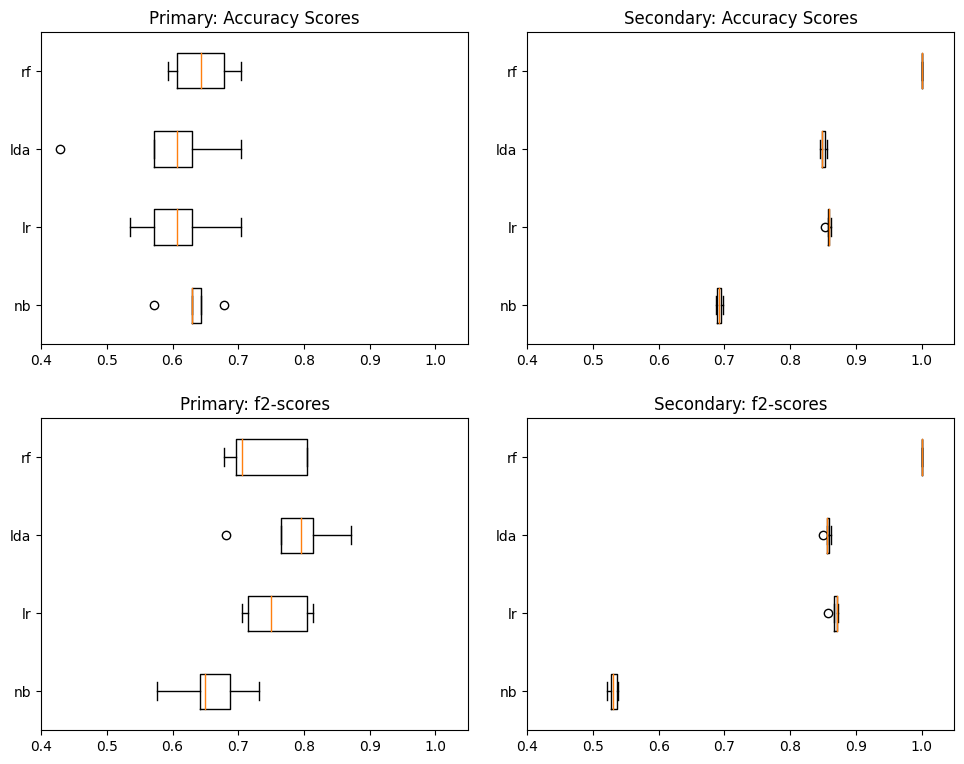

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Create boxplot in the first subplot (top-left)
topleft = results_df.loc[
    (results_df['group']=='primary') & (results_df['scoring_system']=='acc'),
    :
].T.iloc[:, ::-1]

axes[0, 0].boxplot(topleft.iloc[3:], vert=False)
axes[0, 0].set_title('Primary: Accuracy Scores')
axes[0, 0].set_yticklabels(topleft.loc['model'])
axes[0, 0].set_xlim(0.40, 1.05)

# Create boxplot in the second subplot (top-right)
topright = results_df.loc[
    (results_df['group']=='secondary') & (results_df['scoring_system']=='acc'),
    :
].T.iloc[:, ::-1]

axes[0, 1].boxplot(topright.iloc[3:], vert=False)
axes[0, 1].set_title('Secondary: Accuracy Scores')
axes[0, 1].set_yticklabels(topright.loc['model'])
axes[0, 1].set_xlim(0.40, 1.05)
# Create boxplot in the third subplot (bottom-left)
bottomleft = results_df.loc[
    (results_df['group']=='primary') & (results_df['scoring_system']=='f2'),
    :
].T.iloc[:, ::-1]

axes[1, 0].boxplot(bottomleft.iloc[3:], vert=False)
axes[1, 0].set_title('Primary: f2-scores')
axes[1, 0].set_yticklabels(bottomleft.loc['model'])
axes[1, 0].set_xlim(0.40, 1.05)
# Create boxplot in the fourth subplot (bottom-right)
bottomright = results_df.loc[
    (results_df['group']=='secondary') & (results_df['scoring_system']=='f2'),
    :
].T.iloc[:, ::-1]

axes[1, 1].boxplot(bottomright.iloc[3:], vert=False)
axes[1, 1].set_title('Secondary: f2-scores')
axes[1, 1].set_yticklabels(bottomright.loc['model'])
axes[1, 1].set_xlim(0.40, 1.05)

fig.tight_layout(pad=2) # Adjust spacing between subplots
plt.show()

### Figure 5 Replication:

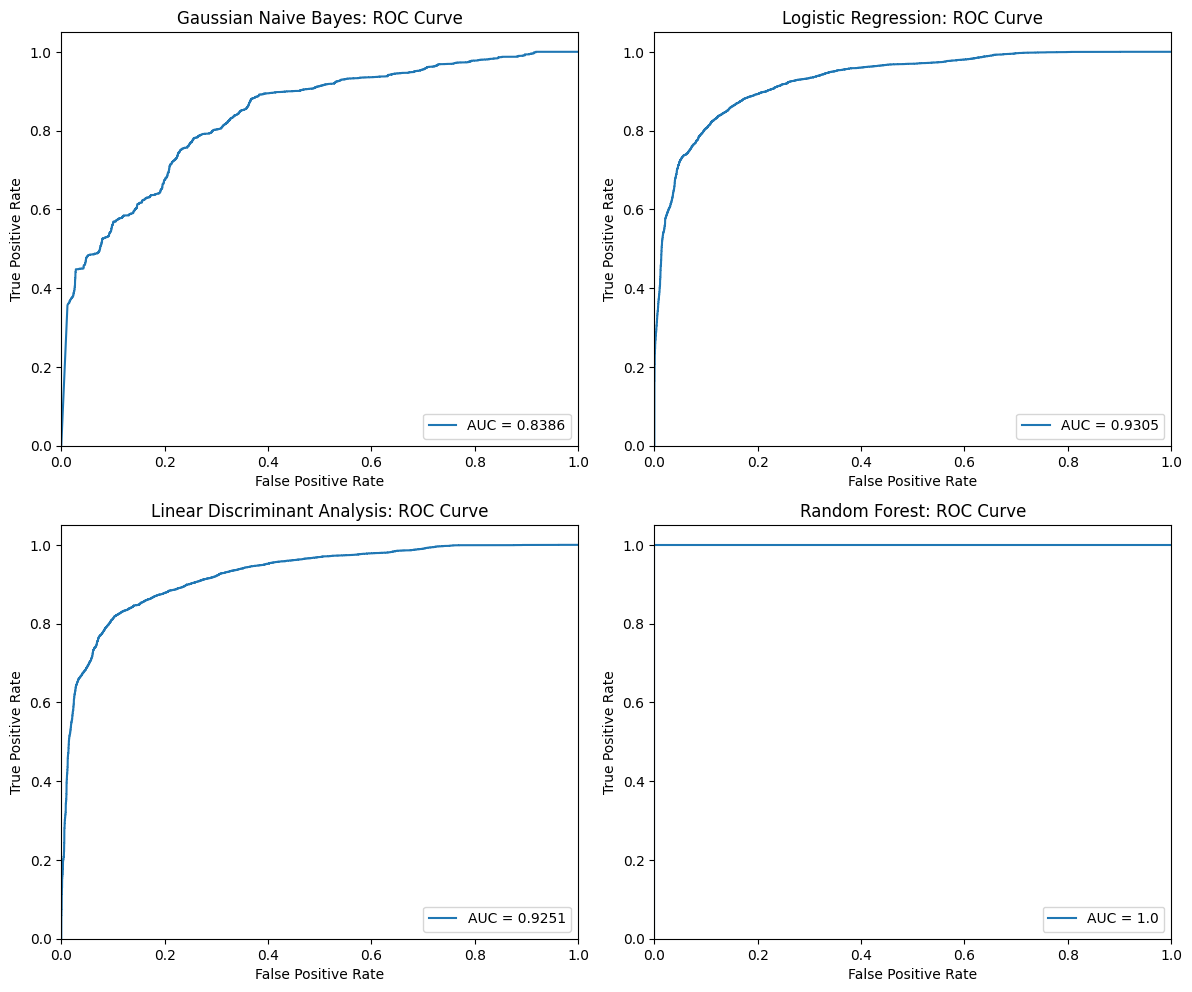

In [15]:
# ROC curves
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# NAIVE BAYES (top-left)
y_scores = secondary['nb_best_estimator'].predict_proba(secondary['X_test'])[:,1]
# .predict_proba returns probability distribution of target variable across different classes
fpr, tpr, _ = roc_curve(secondary['y_test'], y_scores)
roc_auc = auc(fpr, tpr)

axes[0, 0].plot(fpr, tpr, label=f'AUC = {round(roc_auc,4)}')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Gaussian Naive Bayes: ROC Curve')
axes[0, 0].legend(loc="lower right")

# LOGISTIC REGRESSION (top-right)
y_scores = secondary['lr_best_estimator'].predict_proba(secondary['X_test'])[:,1]
# .predict_proba returns probability distribution of target variable across different classes
fpr, tpr, _ = roc_curve(secondary['y_test'], y_scores)
roc_auc = auc(fpr, tpr)

axes[0, 1].plot(fpr, tpr, label=f'AUC = {round(roc_auc,4)}')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Logistic Regression: ROC Curve')
axes[0, 1].legend(loc="lower right")

# LINEAR DISCRIMINANT ANALYSIS (bottom-left)
y_scores = secondary['lda_best_estimator'].predict_proba(secondary['X_test'])[:,1]
# .predict_proba returns probability distribution of target variable across different classes
fpr, tpr, _ = roc_curve(secondary['y_test'], y_scores)
roc_auc = auc(fpr, tpr)

axes[1, 0].plot(fpr, tpr, label=f'AUC = {round(roc_auc,4)}')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Linear Discriminant Analysis: ROC Curve')
axes[1, 0].legend(loc="lower right")


# RANDOM FOREST (bottom-right)
y_scores = secondary['rf_best_estimator'].predict_proba(secondary['X_test'])[:,1]
# .predict_proba returns probability distribution of target variable across different classes
fpr, tpr, _ = roc_curve(secondary['y_test'], y_scores)
roc_auc = auc(fpr, tpr)

axes[1, 1].plot(fpr, tpr, label=f'AUC = {round(roc_auc,4)}')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('Random Forest: ROC Curve')
axes[1, 1].legend(loc="lower right")

# Adjust spacing between subplots and add padding
fig.tight_layout(pad=1)

plt.show()

## Review

A perfect prediction from the dataset was indeed possible, as evidenced above. 

In terms of differences with Wagner et al.'s:
* The exact procedures in original article were left unclear many times. Namely the parameters used for the models.
* Since most of the AUC curves above were actually better than the ones in the original article, it is likely that Wagner et al. did not tune any hyperparameter and simply used five-fold cross validation. 
    * Therefore, the additional layer of cross-validation (see **param_grid**) can be interpreted as a solution provided by this project. This improved the performances of the non-perfect  models.

## Experiment with Deep Learning Model
This is an added extra. A multilayered perception classifier with sklearn will now replicate the perfect score.

In [16]:
param_grid = {
    'activation': ['identity', 'relu'],
    
    'solver': ['adam'], 
    
    'hidden_layer_sizes': [tuple([100 for layer in range(3)])] 
}

grid_search = GridSearchCV(
    MLPClassifier(), 
    param_grid, 
    n_jobs=-1
).fit(X2_train, y2_train)

In [17]:
predicted = grid_search.predict(X2_test)
print(
    grid_search.best_estimator_,
    '\n\n',
    classification_report(
        y2_test, 
        predicted,
    )
)

MLPClassifier(hidden_layer_sizes=(100, 100, 100)) 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5357
           1       1.00      1.00      1.00      6857

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



A perfect score is also possible with a multilayered perceptron as the classifier model. However, the training time is less efficient than the rainforest model. Perhaps this alternative can be considered for other similar contexts. ie. if feature sets are less 'clean'. In that scenario neural networks should better account for more 'noisy' or diverse data. Though for Wagner et al.'s case, there was the luxury of fairly clean data. 

## References

Wagner, D., Heider, D. and Hattab, G. (2021) “Mushroom Data Creation, curation, and simulation to support classification tasks”, Scientific Reports, 11(1). Available at: doi:10.1038/s41598-021-87602-3. 